In [1]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC


In [2]:
# read in dataset
data = pd.read_csv('Occupancy.csv')
# get hour number from datetime column
data['Datetime'] = pd.to_datetime(data['date'])
data['Hour'] = data['Datetime'].dt.hour
# getting the weekday from the 'date' column
data['DOTW'] = pd.to_datetime(data['date']).dt.day_name()
# making the column 'DOTW' to be catergorical and will now be changed to numerical values representing the days of the week
day_mapping = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}
# now mapping the new values to the 'DOTW' column
data['DOTW_encoded'] = data['DOTW'].map(day_mapping)
# create a binary variable for weekday or not
data['Weekday'] = np.where(data['DOTW_encoded'] < 6, 1, 0)
# create a binary variable for working hours or not
data['Working_Hours'] = np.where(np.logical_and(data['Hour'] >= 6, data['Hour'] <= 18), 1, 0)
# create a binary variable for working hours on a weekday
data['Workdayhrs'] = np.where(np.logical_and(data['Weekday'] == 1, data['Working_Hours'] == 1), 1, 0)
# reduce Light variable to binary
data['Light_on_off'] = np.where(data['Light'] > 0, 1, 0)
# keep only desired columns
data1 = data[["Occupancy","Light_on_off","Weekday","Working_Hours","Workdayhrs","Temperature"]].copy()

In [3]:
###SPLIT RANDOMLY
# split data into predictors (X) and target (y)
#X = data[['Temperature', 'Humidity', 'CO2', 'Light', 'HumidityRatio']]
#y = data['Occupancy']

# split into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
###SPLIT SEQUENTIALLY SINCE EACH ROW IS A SUBSEQUENT TIMEPOINT
# calculate index for splitting
split_index = int(len(data) * 0.8)

# split into training and test sets
train_data = data1.iloc[:split_index]
test_data = data1.iloc[split_index:]

# split data into predictors (X) and target (y)

#x predictor: Working_Hours y target: Light_on_off
X_train1 = train_data[['Working_Hours']]
y_train1 = train_data['Light_on_off']
X_test1 = test_data[['Working_Hours']]
y_test1 = test_data['Light_on_off']

#x predictor: Occupancy y target: Light_on_off
X_train2 = train_data[['Occupancy']]
y_train2 = train_data['Light_on_off']
X_test2 = test_data[['Occupancy']]
y_test2 = test_data['Light_on_off']

#x predictor: Temperature y target: Light_on_off
X_train3 = train_data[['Temperature']]
y_train3 = train_data['Light_on_off']
X_test3 = test_data[['Temperature']]
y_test3 = test_data['Light_on_off']


In [5]:
# create function to rerun the neural network with different predictors

def fcdnn(X_train,X_test,y_train,y_test,varname):
    # normalize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    ######
    # create model for fully connected (dense) neural network
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    ######
    # compile model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])
    #######
    # train model
    history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
    ######
    # evaluate model
    evaluation_metrics = model.evaluate(X_test_scaled, y_test)
    ######
    # Print evaluation metrics
    result_list = [round(evaluation_metrics[0],8),round(evaluation_metrics[1],8),round(evaluation_metrics[2],8),round(evaluation_metrics[3],8),round(evaluation_metrics[4],8)]
    ######
    # Predict probabilities
    predicted_probabilities = model.predict(X_test_scaled)
    predicted_labels = predicted_probabilities.flatten()
    # Ensure y_test is in the correct shape
    actual_labels = y_test.values.flatten()
    # Generate a time axis based on the length of the test data
    time_axis = np.arange(len(y_test))
    plt.figure(figsize=(15, 3))
    # Plot actual and predicted values
    plt.plot(time_axis, actual_labels, label='Actual', linewidth=2, color = "aquamarine")
    plt.plot(time_axis, predicted_labels, label='Predicted', linewidth=2, linestyle='--', color = "gold")
    plt.title(f"Comparison of Actual and Predicted Light_on_off Over Time by {varname}")
    plt.xlabel('Time (minutes)')
    plt.ylabel('Light_on_off')
    plt.legend()
    plt.show()
    # save predictions to CSV
    df = pd.DataFrame({'predicted_data': predicted_labels, 'actual_data': y_test})
    df = df.reset_index(drop=True)
    # return result list and dataframe to save to CSV
    return result_list,df


Epoch 1/100
412/412 [==============================] - 2s 2ms/step - loss: 0.3240 - accuracy: 0.8672 - precision: 0.7364 - recall: 0.9942 - auc: 0.8946 - val_loss: 0.3519 - val_accuracy: 0.8371 - val_precision: 0.7276 - val_recall: 1.0000 - val_auc: 0.8558
Epoch 2/100
412/412 [==============================] - 1s 2ms/step - loss: 0.2881 - accuracy: 0.8687 - precision: 0.7366 - recall: 1.0000 - auc: 0.8960 - val_loss: 0.3510 - val_accuracy: 0.8371 - val_precision: 0.7276 - val_recall: 1.0000 - val_auc: 0.8558
Epoch 3/100
412/412 [==============================] - 1s 2ms/step - loss: 0.2880 - accuracy: 0.8687 - precision: 0.7366 - recall: 1.0000 - auc: 0.8943 - val_loss: 0.3506 - val_accuracy: 0.8371 - val_precision: 0.7276 - val_recall: 1.0000 - val_auc: 0.8558
Epoch 4/100
412/412 [==============================] - 1s 2ms/step - loss: 0.2879 - accuracy: 0.8687 - precision: 0.7366 - recall: 1.0000 - auc: 0.8953 - val_loss: 0.3523 - val_accuracy: 0.8371 - val_precision: 0.7276 - val_recal

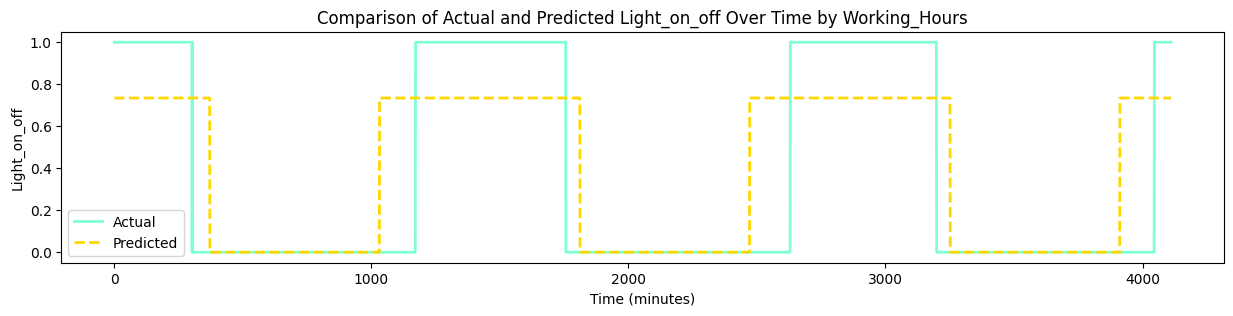

In [6]:
#x predictor: Working_Hours y target: Light_on_off
result1,df1 = fcdnn(X_train1,X_test1,y_train1,y_test1,"Working_Hours")
df1.to_csv("FCDNN_results_lightonoffVSworkinghours.csv")

Epoch 1/100
412/412 [==============================] - 2s 2ms/step - loss: 0.3726 - accuracy: 0.8677 - precision: 1.0000 - recall: 0.6397 - auc: 0.8240 - val_loss: 0.6034 - val_accuracy: 0.7143 - val_precision: 0.9980 - val_recall: 0.3443 - val_auc: 0.6719
Epoch 2/100
412/412 [==============================] - 1s 2ms/step - loss: 0.3439 - accuracy: 0.8729 - precision: 1.0000 - recall: 0.6538 - auc: 0.8281 - val_loss: 0.6245 - val_accuracy: 0.7143 - val_precision: 0.9980 - val_recall: 0.3443 - val_auc: 0.6719
Epoch 3/100
412/412 [==============================] - 1s 2ms/step - loss: 0.3435 - accuracy: 0.8729 - precision: 1.0000 - recall: 0.6538 - auc: 0.8307 - val_loss: 0.6224 - val_accuracy: 0.7143 - val_precision: 0.9980 - val_recall: 0.3443 - val_auc: 0.6719
Epoch 4/100
412/412 [==============================] - 1s 2ms/step - loss: 0.3438 - accuracy: 0.8729 - precision: 1.0000 - recall: 0.6538 - auc: 0.8257 - val_loss: 0.6065 - val_accuracy: 0.7143 - val_precision: 0.9980 - val_recal

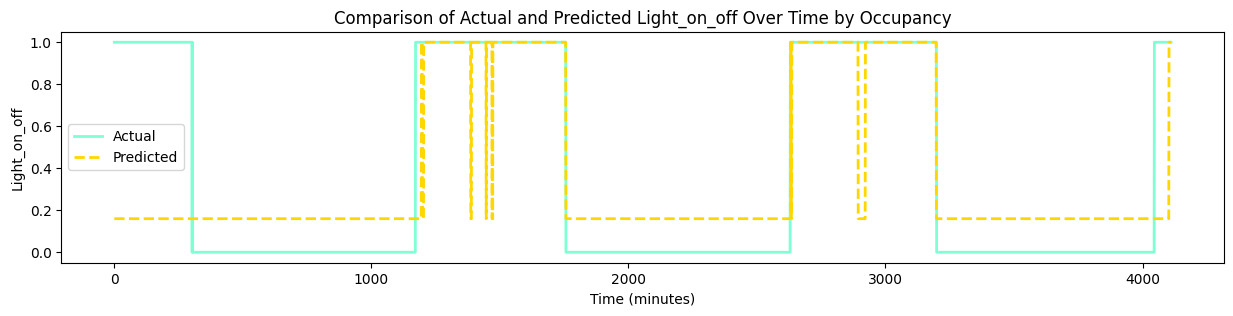

In [7]:
#x predictor: Occupancy y target: Light_on_off
result2,df2 = fcdnn(X_train2,X_test2,y_train2,y_test2,"Occupancy")
df2.to_csv("FCDNN_results_lightonoffVSoccupancy.csv")

Epoch 1/100
412/412 [==============================] - 2s 2ms/step - loss: 0.4531 - accuracy: 0.8241 - precision: 0.8200 - recall: 0.6674 - auc: 0.8237 - val_loss: 0.5187 - val_accuracy: 0.7745 - val_precision: 1.0000 - val_recall: 0.4818 - val_auc: 0.6655
Epoch 2/100
412/412 [==============================] - 1s 2ms/step - loss: 0.4197 - accuracy: 0.8312 - precision: 0.8533 - recall: 0.6525 - auc: 0.8453 - val_loss: 0.5288 - val_accuracy: 0.7757 - val_precision: 1.0000 - val_recall: 0.4846 - val_auc: 0.6613
Epoch 3/100
412/412 [==============================] - 1s 2ms/step - loss: 0.4186 - accuracy: 0.8304 - precision: 0.8489 - recall: 0.6546 - auc: 0.8479 - val_loss: 0.5397 - val_accuracy: 0.7754 - val_precision: 1.0000 - val_recall: 0.4839 - val_auc: 0.6938
Epoch 4/100
412/412 [==============================] - 1s 2ms/step - loss: 0.4182 - accuracy: 0.8311 - precision: 0.8511 - recall: 0.6544 - auc: 0.8495 - val_loss: 0.5430 - val_accuracy: 0.7745 - val_precision: 1.0000 - val_recal

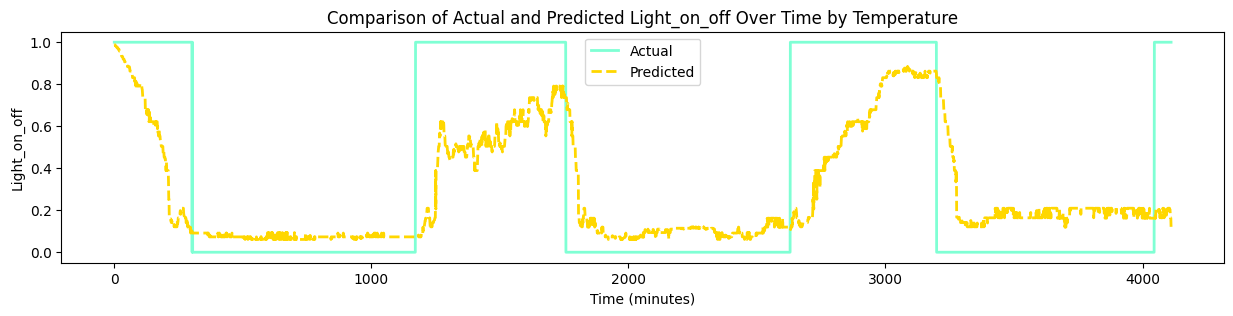

In [8]:
#x predictor: Temperature y target: Light_on_off
result3,df3 = fcdnn(X_train3,X_test3,y_train3,y_test3,"Temperature")
df3.to_csv("FCDNN_results_lightonoffVStemperature.csv")

In [9]:
# create dataframe to contain all results
templists = [result1,result2,result3]
fcdnn_results = pd.DataFrame(templists)
fcdnn_results.columns=['Test Loss', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test AUC']
fcdnn_results = fcdnn_results.rename(index={0: 'Working_Hours',1: 'Occupancy',2: 'Temperature'})
fcdnn_results

,Test Loss,Test Accuracy,Test Precision,Test Recall,Test AUC
Working_Hours,0.310436,0.852140,0.714822,1.000000,0.882535
Occupancy,0.299999,0.896158,1.000000,0.719816,0.859908
Temperature,0.390315,0.847276,0.910256,0.652231,0.917770
